In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
df = pd.read_csv("/content/Train.csv")

In [ ]:
df.dropna(subset=['PM2.5'], inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
training_set = df.iloc[:, 5:6].values
len(training_set)

27233

In [ ]:
training_set = training_set[-5000:]

In [ ]:
training_set.shape

(5000, 1)

In [ ]:
# normalize your data for BiGRU
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour.
n_obs = 5000  # Total number of hourly observations in your training set.

X_train = []
y_train = []

for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, 0])  # The previous 48 hours' data.2 days
    y_train.append(training_set_scaled[i, 0])  # The current hour's data to predict.

# Convert lists to numpy arrays for training the BiGRU.
X_train, y_train = np.array(X_train), np.array(y_train)

# Check the shape of X_train to understand the dimensions of the input data.
X_train.shape

(4952, 48)

In [ ]:
# specify or add indicators(here 1, ph)
# keras documentation-> Recurrent Layers -> Input shape: (batch_size,timesteps,input_dim)
batch_size = X_train.shape[0]
timesteps = X_train.shape[1]

X_train = np.reshape(X_train, (batch_size, timesteps, 1))

Bi GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dropout, Dense
from keras.activations import relu

model = Sequential()

# Adding the first Bi-GRU layer with 200 units and ReLU activation
model.add(Bidirectional(GRU(units=200, return_sequences=True, activation='relu'),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))

# Adding the second Bi-GRU layer with 100 units and ReLU activation
model.add(Bidirectional(GRU(units=100, return_sequences=True, activation='relu')))
model.add(Dropout(rate=0.1))

# Adding the third Bi-GRU layer with 50 units and ReLU activation
model.add(Bidirectional(GRU(units=50, return_sequences=True, activation='relu')))
model.add(Dropout(rate=0.1))

# Adding the last Bi-GRU layer with 50 units and ReLU activation
# Typically return_sequences=False is used for the last layer when connecting to a Dense layer for prediction.
model.add(Bidirectional(GRU(units=50, activation='relu')))
model.add(Dropout(rate=0.1))

# Adding the output layer with a single neuron
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 48, 400)           243600    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 48, 200)           301200    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 48, 200)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 48, 100)           75600     
 onal)                                                           
                                                        

Fitting the BI GRU to the Training set

In [ ]:
# Compiling the BiGRU
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
155/155 [==============================] - 76s 413ms/step - loss: 0.0030
Epoch 2/50
155/155 [==============================] - 62s 398ms/step - loss: 0.0014
Epoch 3/50
155/155 [==============================] - 63s 409ms/step - loss: 0.0013
Epoch 4/50
155/155 [==============================] - 63s 404ms/step - loss: 0.0011
Epoch 5/50
155/155 [==============================] - 62s 398ms/step - loss: 0.0010
Epoch 6/50
155/155 [==============================] - 62s 398ms/step - loss: 0.0011
Epoch 7/50
155/155 [==============================] - 62s 399ms/step - loss: 0.0012
Epoch 8/50
155/155 [==============================] - 63s 407ms/step - loss: 0.0010
Epoch 9/50
155/155 [==============================] - 62s 398ms/step - loss: 0.0010
Epoch 10/50
155/155 [==============================] - 63s 409ms/step - loss: 9.8848e-04
Epoch 11/50
155/155 [==============================] - 62s 399ms/step - loss: 9.8220e-04
Epoch 12/50
155/155 [==============================] - 63s 408ms/s

In [ ]:
# transform and create sequences for Test data
dataset_test = pd.read_csv('/content/Test.csv')

In [ ]:
dataset_test.dropna(subset=['PM2.5'], inplace=True)

In [ ]:
real_PM2 = dataset_test['PM2.5'].values
real_PM2

array([10., 26., 11., ..., 16., 21., 19.])

In [ ]:
# Convert numpy arrays to pandas DataFrames
training_set_df = pd.DataFrame(training_set, columns=['PM2.5'])
dataset_test_df = pd.DataFrame(dataset_test, columns=['PM2.5'])

# Concatenate the two DataFrames along the axis=0 (vertically)
data_set_total = pd.concat([training_set_df, dataset_test_df], axis=0)
data_set_total

,PM2.5
0,21.0
1,22.0
2,27.0
3,26.0
4,27.0
...,...
7008,12.0
7009,13.0
7010,16.0
7011,21.0


In [ ]:
data_set_total.reset_index(drop=True, inplace=True)

In [ ]:

inputs = data_set_total[len(data_set_total)- len(dataset_test) - 48:].values
# reshape inputs to get a numpy array with rows and one column
inputs = inputs.reshape(-1,1)
# scale inputs (like what we did with training set)
inputs = sc.transform(inputs)
X_test = []
# test set contains 7012 observations
for i in range (48,inputs.shape[0]):
  X_test.append(inputs[i-48:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))

In [ ]:
X_test.shape

(6906, 48, 1)

In [ ]:
pred_PM2 = model.predict(X_test)
pred_PM2

216/216 [==============================] - 30s 133ms/step


array([[0.0119371 ],
       [0.01148207],
       [0.02303588],
       ...,
       [0.01202379],
       [0.01417445],
       [0.0189066 ]], dtype=float32)

In [ ]:
pred_PM2 = model.predict(X_test)
# rescale to original format
pred_PM2 = sc.inverse_transform(pred_PM2)
RMSE = np.sqrt(np.mean((pred_PM2 - real_PM2)**2))
RMSE

216/216 [==============================] - 30s 140ms/step


120.65161143525268

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2, pred_PM2))

# Calculate MAE
mae = mean_absolute_error(real_PM2, pred_PM2)

# Calculate MSE
mse = mean_squared_error(real_PM2, pred_PM2)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2 - pred_PM2) / real_PM2)) * 100

# Calculate R-squared
r2 = r2_score(real_PM2, pred_PM2)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 19.2041
MAE: 10.5903
MSE: 368.7981
MAPE: 304.1861%
R-squared: 0.9477


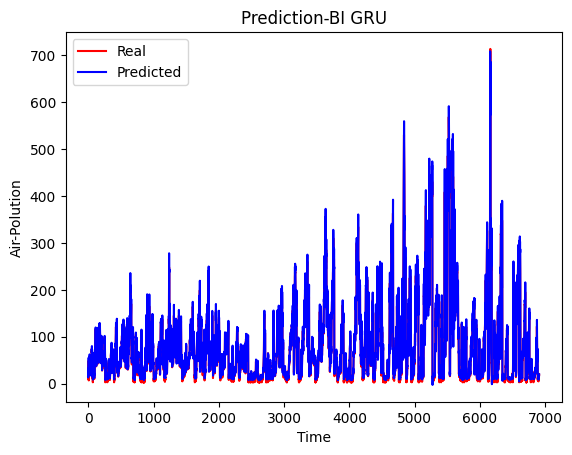

In [ ]:
plt.plot(real_PM2, color = 'red', label = 'Real')
plt.plot(pred_PM2, color = 'blue', label = 'Predicted')
plt.title('Prediction-BI GRU')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()